<a href="https://colab.research.google.com/github/7amzaGH/COVID-19-X-ray-Image-Classification-using-Transfer-Learning-VGG16/blob/main/COVID_19_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COVID-19 X-ray Image Classification using Transfer Learning (VGG16)**

# **1-Imports**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2-Data Loading and Preparation**

In [ ]:
!unzip /content/drive/MyDrive/Classroom/COVID19-20220609T100554Z-001.zip

Archive:  /content/drive/MyDrive/Classroom/COVID19-20220609T100554Z-001.zip
  inflating: COVID19/normal/93.png   
  inflating: COVID19/normal/114.png  
  inflating: COVID19/normal/105.png  
  inflating: COVID19/normal/92.png   
  inflating: COVID19/normal/108.png  
  inflating: COVID19/normal/120.png  
  inflating: COVID19/normal/106.png  
  inflating: COVID19/normal/101.png  
  inflating: COVID19/normal/110.png  
  inflating: COVID19/normal/98.png   
  inflating: COVID19/normal/96.png   
  inflating: COVID19/normal/118.png  
  inflating: COVID19/normal/109.png  
  inflating: COVID19/normal/107.png  
  inflating: COVID19/normal/112.png  
  inflating: COVID19/normal/103.png  
  inflating: COVID19/normal/116.png  
  inflating: COVID19/normal/97.png   
  inflating: COVID19/normal/115.png  
  inflating: COVID19/normal/113.png  
  inflating: COVID19/normal/102.png  
  inflating: COVID19/normal/99.png   
  inflating: COVID19/normal/117.png  
  inflating: COVID19/normal/95.png   
  inflating:

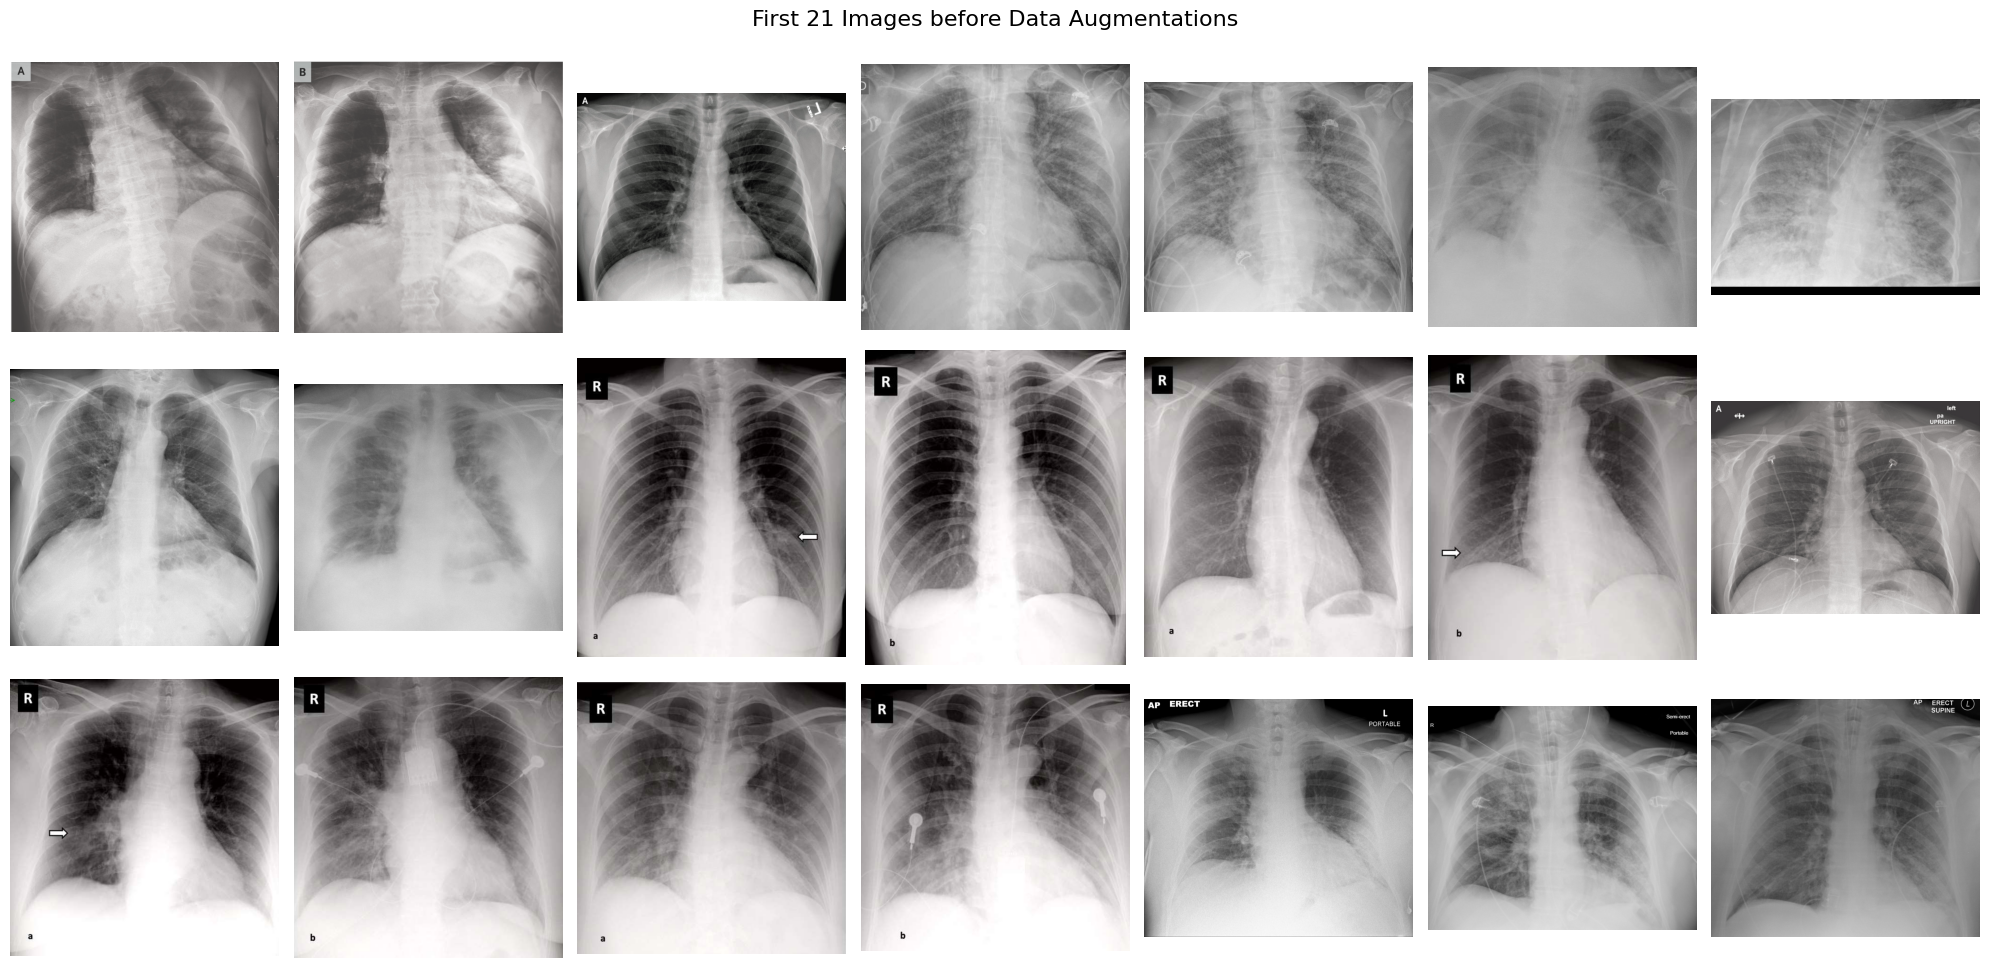

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Directory containing images
image_dir = "/content/COVID19/covid19"

# Get a list of all image files in the directory
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))])

# Ensure there are enough images to plot
if len(image_files) < 21:
    print("Not enough images to display. Found only:", len(image_files))
else:
    # Create a 3x7 grid for displaying the first 21 images
    fig, axes = plt.subplots(3, 7, figsize=(20, 10))
    fig.suptitle("First 21 Images before Data Augmentations", fontsize=16)

    for i, ax in enumerate(axes.flat):
        # Load the image
        img = Image.open(image_files[i])
        ax.imshow(img)
        ax.axis('off')  # Turn off axis

    plt.tight_layout()
    plt.show()



# **2.2-Data Augmentation**

In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor

# Augmentation pipeline for COVID-19 class
p_covid = Augmentor.Pipeline("/content/COVID19/covid19")

# Add augmentations
p_covid.zoom(probability=0.3, min_factor=0.9, max_factor=1.2)
p_covid.flip_left_right(probability=0.4)
p_covid.random_brightness(probability=0.3, min_factor=0.8, max_factor=1.2)
p_covid.rotate(probability=0.5, max_left_rotation=5, max_right_rotation=5)
p_covid.gaussian_distortion(probability=0.3, grid_width=4, grid_height=4, magnitude=2, corner="bell", method="in")

# Generate augmented samples
p_covid.sample(700)


Initialised with 121 image(s) found.
Output directory set to /content/COVID19/covid19/output.

Processing <PIL.Image.Image image mode=RGB size=1165x1163 at 0x7BC6B44088B0>: 100%|██████████| 700/700 [10:43<00:00,  1.09 Samples/s]


In [ ]:
import Augmentor


p_covid = Augmentor.Pipeline("/content/COVID19/normal")

# Slight zoom to mimic variations in imaging distances
# Add augmentations
p_covid.zoom(probability=0.3, min_factor=0.9, max_factor=1.2)
p_covid.flip_left_right(probability=0.4)
p_covid.random_brightness(probability=0.3, min_factor=0.8, max_factor=1.2)
p_covid.rotate(probability=0.5, max_left_rotation=5, max_right_rotation=5)
p_covid.gaussian_distortion(probability=0.3, grid_width=4, grid_height=4, magnitude=2, corner="bell", method="in")

# Generate augmented samples
p_covid.sample(700)


Initialised with 121 image(s) found.
Output directory set to /content/COVID19/normal/output.

Processing <PIL.Image.Image image mode=RGB size=1862x1326 at 0x7BC6CC58D300>: 100%|██████████| 700/700 [12:05<00:00,  1.04s/ Samples]


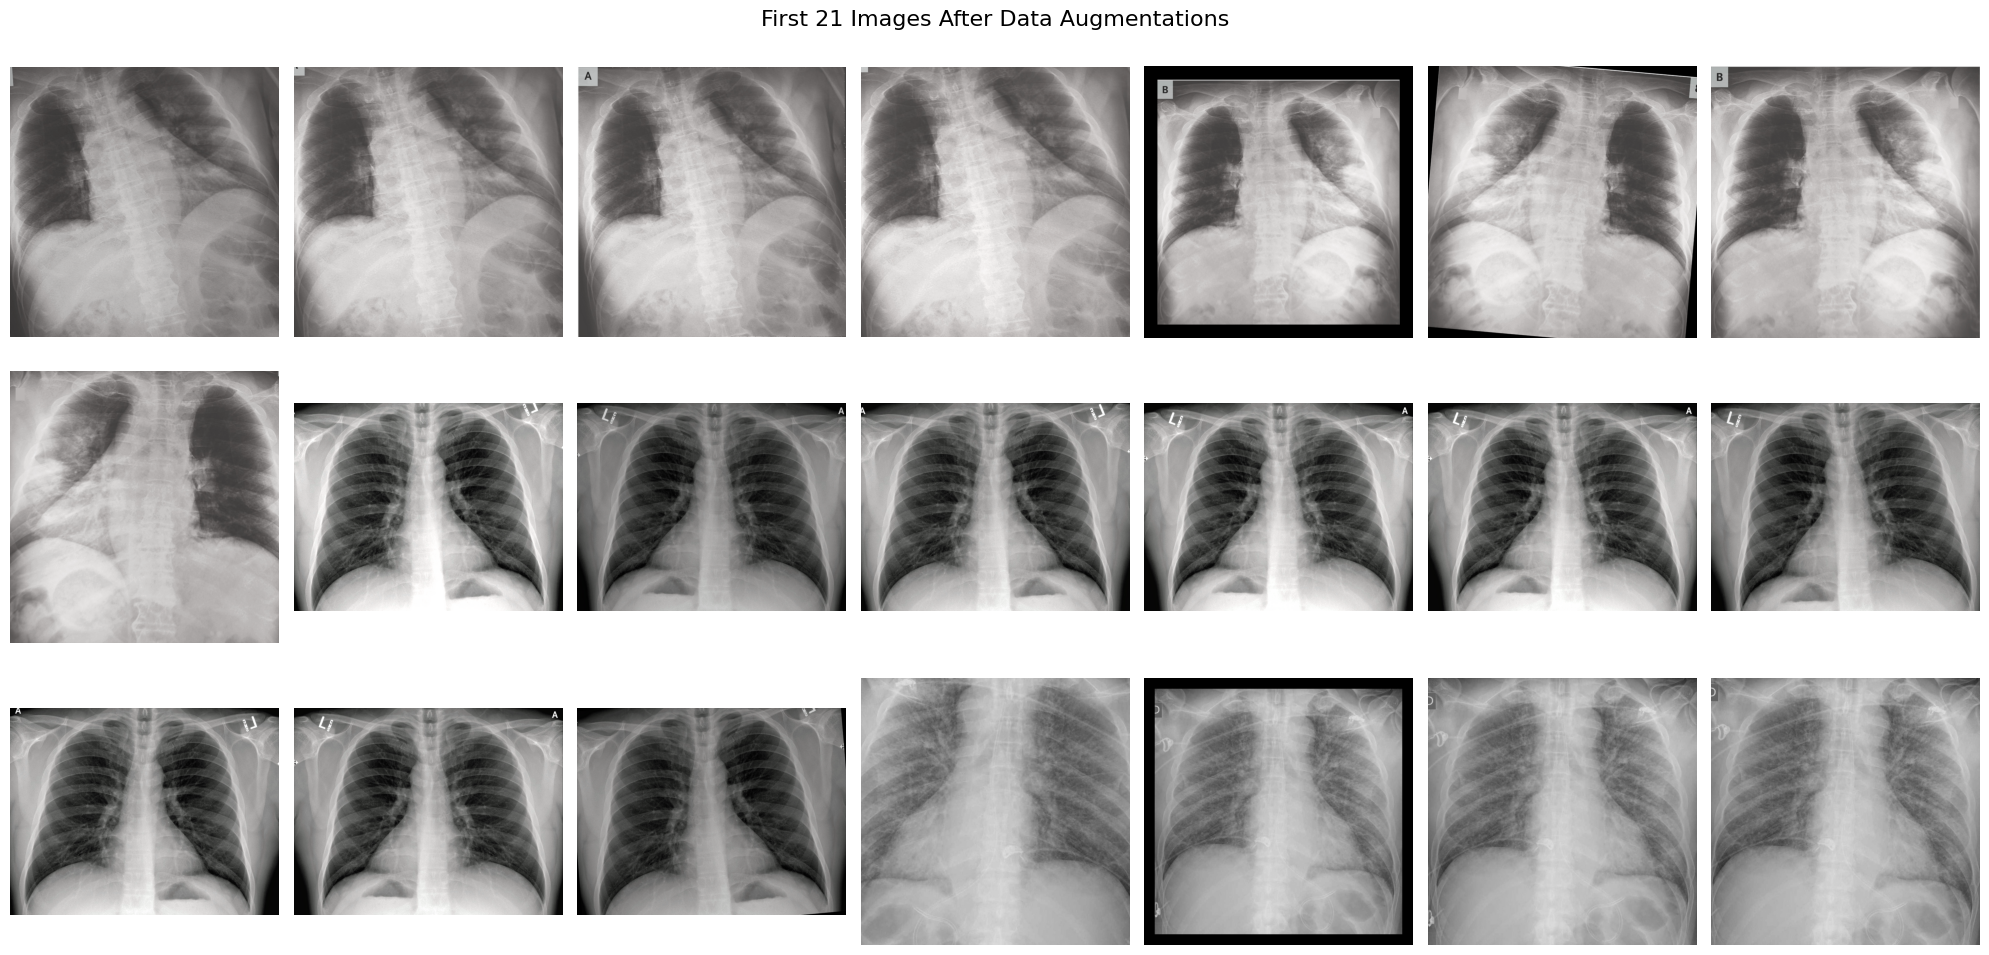

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Directory containing images
image_dir = "/content/COVID19/covid19/output"

# Get a list of all image files in the directory
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))])

# Ensure there are enough images to plot
if len(image_files) < 21:
    print("Not enough images to display. Found only:", len(image_files))
else:
    # Create a 3x7 grid for displaying the first 21 images
    fig, axes = plt.subplots(3, 7, figsize=(20, 10))
    fig.suptitle("First 21 Images After Data Augmentations", fontsize=16)

    for i, ax in enumerate(axes.flat):
        # Load the image
        img = Image.open(image_files[i])
        ax.imshow(img)
        ax.axis('off')  # Turn off axis

    plt.tight_layout()
    plt.show()


# **3-Data splitting**

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

base_dir = "/content/COVID19"
covid_dir = os.path.join(base_dir, "covid19/output")
normal_dir = os.path.join(base_dir, "normal/output")

In [ ]:
# Directories for split dataset
output_dir = "/content/split_dataset"
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")  # Validation directory
test_dir = os.path.join(output_dir, "test")

# Create directories for each category in train/val/test
for category in ["covid19", "normal"]:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

# Function to split data into train, validation, and test
def split_data(source_dir, train_dest, val_dest, test_dest, val_size=0.1, test_size=0.2):
    all_files = os.listdir(source_dir)
    all_files = [os.path.join(source_dir, f) for f in all_files]

    # Split into train/test first
    train_files, test_files = train_test_split(all_files, test_size=test_size, random_state=42)
    # Further split train into train/validation
    train_files, val_files = train_test_split(train_files, test_size=val_size / (1 - test_size), random_state=42)

    # Copy files to respective directories
    for f in train_files:
        shutil.copy(f, train_dest)
    for f in val_files:
        shutil.copy(f, val_dest)
    for f in test_files:
        shutil.copy(f, test_dest)

# Apply the function for each category
split_data(covid_dir, os.path.join(train_dir, "covid19"), os.path.join(val_dir, "covid19"), os.path.join(test_dir, "covid19"))
split_data(normal_dir, os.path.join(train_dir, "normal"), os.path.join(val_dir, "normal"), os.path.join(test_dir, "normal"))


# **4-Data Normalization**

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 980 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


# **5-Class Weighting**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
y_train = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# **6-Model Architecture**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

# Load the VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a Sequential model
model = Sequential()

# Add the base model
model.add(base_model)

# Add custom layers
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Make sure the base model's layers are not trainable
base_model.trainable = False




In [ ]:
for layer in base_model.layers:
    layer.trainable = False

# **Model Compilation and Training**

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 826s 26s/step - accuracy: 0.9401 - loss: 0.2434 - val_accuracy: 0.9143 - val_loss: 0.2138
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 833s 26s/step - accuracy: 0.9458 - loss: 0.1887 - val_accuracy: 0.9143 - val_loss: 0.1962
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 876s 27s/step - accuracy: 0.9527 - loss: 0.1820 - val_accuracy: 0.9357 - val_loss: 0.1686
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 844s 27s/step - accuracy: 0.9614 - loss: 0.1443 - val_accuracy: 0.9500 - val_loss: 0.1549
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 823s 25s/step - accuracy: 0.9575 - loss: 0.1419 - val_accuracy: 0.9357 - val_loss: 0.1538
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 867s 25s/step - accuracy: 0.9650 - loss: 0.1155 - val_accuracy: 0.9500 - val_loss: 0.1396
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 882s 26s/step - accuracy: 0.9631 - loss: 0.1140 - val_accuracy: 0.9643 - val_loss: 0.1289
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 887s 27s/step - accuracy: 0.9653 - loss: 0.1226 - val_accuracy: 0.

# **Results and Evaluation**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype('int32')

print(classification_report(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))

9/9 ━━━━━━━━━━━━━━━━━━━━ 204s 22s/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       140
           1       0.96      0.98      0.97       140

    accuracy                           0.97       280
   macro avg       0.97      0.97      0.97       280
weighted avg       0.97      0.97      0.97       280

F1 Score: 0.9716312056737588


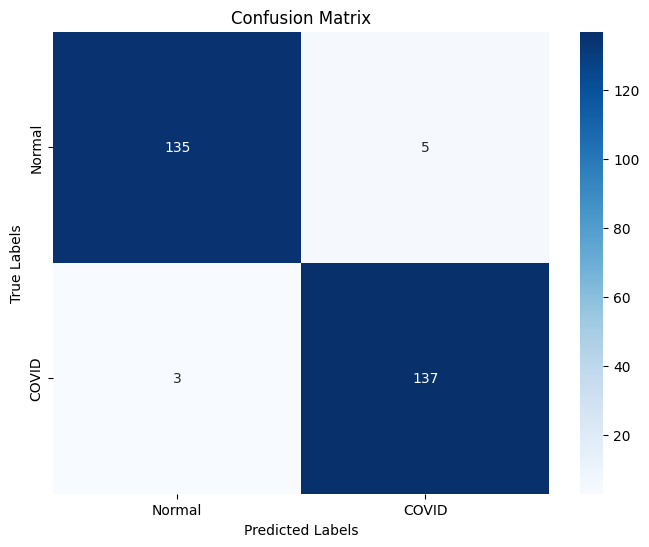

In [ ]:
import seaborn as sns
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "COVID"], yticklabels=["Normal", "COVID"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

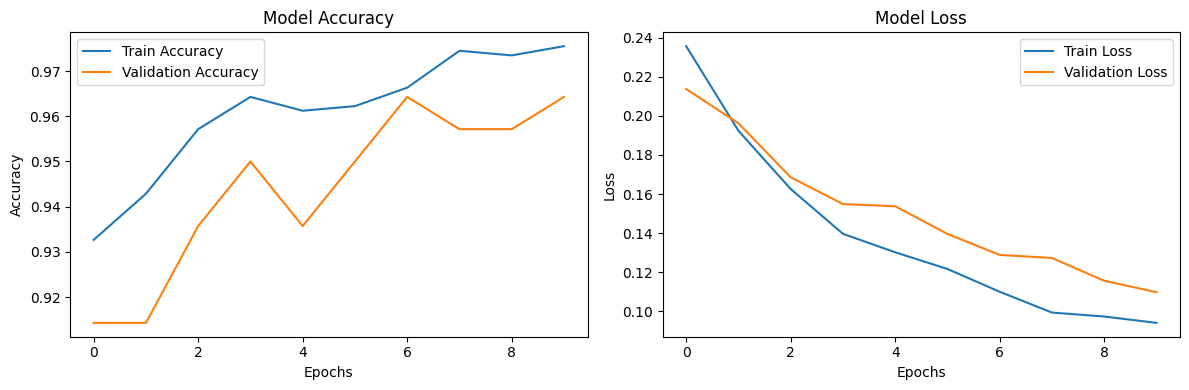

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save('covid19_cnn.keras')

In [ ]:
model.save('covid19_cnn.h5')